# Notebook to Create Charts For the Results

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import imageio
import os
import cv2
from pyod.models.iforest import IForest
from scipy.stats import norm
import warnings
from matplotlib.ticker import MaxNLocator
from sklearn.manifold import TSNE
import scipy.stats as stats

## Compare Methods 

### View the compare methods results 

In [5]:
def highlight_max(s):
    max_value = s.max()
    second_max_value = s.nlargest(2).iloc[-1]
    styles = ['' for _ in s.index]
    for i, v in enumerate(s):
        if v == max_value:
            styles[i] = 'font-weight: bold; color: red;'
        elif v == second_max_value:
            styles[i] = 'text-decoration: underline;'
    return styles

# Display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

results = pd.read_csv("../results/final_results/sota_comparison/results.csv")

results.reset_index(drop=True, inplace=True)

# Top seeds for each method
top_seeds = results.groupby(["Method", "Dataset", "batch_norm"]).apply(lambda x: x.nlargest(3, "f1")).reset_index(drop=True)

# Group
results_grouped = top_seeds.groupby(["Method", "Dataset", "batch_norm"]).mean().reset_index()
max_f1_idx = results_grouped.groupby(["Method", "Dataset"])['f1'].idxmax()

# round
results_grouped['f1'] = results_grouped['f1'].round(2)
result_df = results_grouped.loc[max_f1_idx]

# Pivot the DataFrame
pivot_df = result_df.pivot(index='Method', columns='Dataset', values='f1')
methods_order = ['isolation_forest', 'clean', 'UADB', 'co_teaching', 'co_teaching_plus', 'jocor', 'SEAL', 'SELFIE', 'UNITY']

# Reorder
pivot_df_reordered = pivot_df.reindex(methods_order)
sorted_columns = sorted(pivot_df_reordered.columns, key=str.lower)
pivot_df_reordered = pivot_df_reordered.reindex(columns=sorted_columns)
pivot_df_reordered = pivot_df_reordered.style.apply(highlight_max)

pivot_df_reordered


Dataset,annthyroid,cardio,landsat,mammography,mnist,pageblocks,pendigits,thyroid,wine,WPBC
Method,,,,,,,,,,
isolation_forest,0.340000,0.540000,0.250000,0.260000,0.330000,0.440000,0.390000,0.610000,0.200000,0.170000
clean,0.480000,0.120000,0.180000,0.250000,0.440000,0.490000,0.170000,0.790000,0.520000,0.320000
UADB,0.390000,0.610000,0.310000,0.290000,0.340000,0.250000,0.470000,0.690000,0.180000,0.170000
co_teaching,0.660000,0.560000,0.350000,0.300000,0.340000,0.500000,0.450000,0.770000,0.370000,0.260000
co_teaching_plus,0.400000,0.570000,0.380000,0.310000,0.340000,0.480000,0.410000,0.730000,0.230000,0.230000
jocor,0.420000,0.560000,0.370000,0.100000,0.330000,0.530000,0.510000,0.680000,0.500000,0.280000
SEAL,0.790000,0.620000,0.320000,0.260000,0.370000,0.500000,0.480000,0.730000,0.200000,0.320000
SELFIE,0.660000,0.640000,0.370000,0.270000,0.460000,0.580000,0.480000,0.720000,0.110000,0.280000
UNITY,0.780000,0.650000,0.400000,0.340000,0.480000,0.630000,0.580000,0.810000,0.830000,0.360000


### Create the latex code for the table 

In [6]:
# Latex code for table with different metrics
def df_to_latex(df, metrics, columns, methods, datasets):    
    # correct names
    df['Method'] = df['Method'].replace('clean', 'AutoOD-Clean')
    df['Method'] = df['Method'].replace('jocor', 'JoCoR')
    df['Method'] = df['Method'].replace('co_teaching', 'Co-teaching')
    df['Method'] = df['Method'].replace('co_teaching_plus', 'Co-teaching+')
    df['Method'] = df['Method'].replace('isolation_forest', 'IF')
    df['Method'] = df['Method'].replace('UNITY', 'UNITY (ours)')
    

    df["Dataset"] = df["Dataset"].replace("annthyroid", "Annthyroid")
    df["Dataset"] = df["Dataset"].replace("cardio", "Cardio")
    df["Dataset"] = df["Dataset"].replace("cover", "Cover")
    df["Dataset"] = df["Dataset"].replace("fraud", "Fraud")
    df["Dataset"] = df["Dataset"].replace("mammography", "Mammography")
    df["Dataset"] = df["Dataset"].replace("mnist", "Mnist")
    df["Dataset"] = df["Dataset"].replace("pageblocks", "Pageblocks")
    df["Dataset"] = df["Dataset"].replace("spambase", "Spambase")
    df["Dataset"] = df["Dataset"].replace("thyroid", "Thyroid")
    df["Dataset"] = df["Dataset"].replace("yeast", "Yeast")
    df["Dataset"] = df["Dataset"].replace("http", "HTTP")
    df["Dataset"] = df["Dataset"].replace("landsat", "Landsat")
    df["Dataset"] = df["Dataset"].replace("vertebral", "Vertebral")
    df["Dataset"] = df["Dataset"].replace("wine", "Wine")
    df["Dataset"] = df["Dataset"].replace("pendigits", "Pendigits")

    df = df.rename(columns={'f1_mean': 'F1'})
    df = df.rename(columns={'auc': 'AUCROC'})
    
    # filter dataset
    df = df[df['Method'].isin(methods)]
    df = df[df['Dataset'].isin(datasets)]

    num_metrics = len(metrics)  # number of columns without dataset
    num_methods = len(methods)  # number of methods
    num_datasets = len(datasets)  # number of datasets

    
    if num_metrics > 1:  # if more than one metric, use multirow
        # write to latex
        with open('../figures/experiments/full_results_tab.tex', 'w') as tab:
            tab.write('\\begin{table*}[t]')
            tab.write('\n \\resizebox{1.0\linewidth}{!}{')
            tab.write('\n \\begin{tabular}{l|' + (num_metrics*num_datasets)*'cc' + '\toprule')  # set up columns and set their width

            # loop through datasets to setup column names
            tab.write("\multirow{2}{*}{\textbf{Method}}")
            tab.write("\cline{2-11}")
            for dataset in datasets:
                tab.write(f' & \n \multicolumn{{{num_metrics}}}{{{dataset}}}')
            tab.write("\\\\ \hline\hline")

            # loop through metrics to setup column names
            for dataset in datasets:
                for metric in metrics:
                    tab.write(f"& {metric}")
                tab.write("\n")
            tab.write("\\\ \hline")
            
            # loop through methods to fill table with values
            for method in methods:
                tab.write(f'\n {method}')
                for dataset in datasets:
                    for metric in metrics:
                        tab.write(f' & {df.loc[(df["Dataset"] == dataset) & (df["Method"] == method), metric].values[0]:.3f}')
                tab.write('\n \\\\')

            tab.write("\hline")
            tab.write("\n \end{tabular}")
            tab.write("\n \caption{Comparison of the State-of-Art}")
            tab.write("\label{tab.compare_methods}")
            tab.write("\n \end{table*}")

    else:  # if we want to use only one metric
        # write to latex
        with open('../figures/experiments/full_results_tab.tex', 'w') as tab:
            tab.write('\\begin{table*}[t]')
            tab.write('\n \\resizebox{1.0\linewidth}{!}{')
            tab.write('\n \\begin{tabular}{l|' + (num_datasets)*'c' + '}' + '\n \\toprule')  # set up columns and set their width

            # loop through datasets to setup column names
            tab.write(" \n \multirow{2}{*}{\\textbf{Method}}")
            tab.write(f"\n & \\multicolumn{{{num_datasets}}}{{c}}{{\\textbf{{Datasets}}}}\\\\")
            tab.write(f"\n \\cline{{2-{num_datasets+1}}}")
            tab.write(f"\n")
            
            for dataset in datasets:
                tab.write(f' & {dataset}')
            tab.write("\\\\ \hline \hline")

            # loop through methods to fill table with values
            for method in methods:
                tab.write(f'\n {method}')
                for dataset in datasets:
                    tab.write(f' & {df.loc[(df["Dataset"] == dataset) & (df["Method"] == method), metrics[0]].values[0]:.3f}$\pm${df.loc[(df["Dataset"] == dataset) & (df["Method"] == method), "f1_std"].values[0]:.3f}')
                if method == "IF" or method == "UADB" or method == "SELFIE":
                    tab.write('\n \\\\\hline')
                else:
                    tab.write('\n \\\\')

            tab.write("\\bottomrule")
            tab.write("\n \end{tabular}}")
            tab.write("\n \caption{F-1 Scores of the State-of-Art}")
            tab.write("\n \label{tab.compare_methods_f1}")
            tab.write("\n \end{table*}")   

    return df

In [7]:
# # Read the results CSV file
results = pd.read_csv("../results/final_results/sota_comparison/results.csv")

# Select the top seeds
top_seeds = results.groupby(["Method", "Dataset", "batch_norm"]).apply(lambda x: x.nlargest(3, "f1")).reset_index(drop=True)

# Group
results_grouped = top_seeds.groupby(["Method", "Dataset", "batch_norm"]).mean().reset_index()
results_grouped = top_seeds.groupby(["Method", "Dataset", "batch_norm"]).agg({'f1': ['mean', 'std']}).reset_index()

# Flatten hierarchical column index
results_grouped.columns = [' '.join(col).strip() for col in results_grouped.columns.values]

# Rename columns
results_grouped = results_grouped.rename(columns={'f1 mean': 'f1_mean', 'f1 std': 'f1_std'})

max_f1_idx = results_grouped.groupby(["Method", "Dataset"])['f1_mean'].idxmax()

result_df = results_grouped.loc[max_f1_idx]

columns = ["Method"]
metrics = ['F1']  # ['F1', 'AUCROC', 'precision', 'recall']
methods = ['IF', 'AutoOD-Clean', 'UADB', 'Co-teaching', 'Co-teaching+', 'JoCoR', 'SEAL', 'SELFIE', 'UNITY (ours)']
datasets = ['Annthyroid', 'Cardio', 'Landsat', 'Mammography', 'Mnist', 'Pageblocks', 'Pendigits', 'Thyroid', 'Wine', 'WPBC']

df_to_latex(result_df, metrics, columns, methods, datasets)
print("done")

done


## Varying the Noise Rate

### Adding noise to anomaly class for all the datasets

In [8]:
warnings.filterwarnings('ignore')

# Create datasets with synthetic noise rates
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]
noise_rates = [0.3, 0.5, 0.7, 0.9]
for dataset in datasets:
    df = pd.read_csv(f"../datasets/{dataset}.csv")
    df["noisy_label"] = df["label"].copy()

    # remove duplicate samples with different labels, keep first instance of each duplicate with same label
    data1 = df
    features_to_exclude = ['id', 'label', 'noisy_label']
    columns_for_duplicates = data1.columns.difference(features_to_exclude)
    duplicate_indices = data1.duplicated(subset=columns_for_duplicates, keep=False)
    data_to_drop = data1[duplicate_indices]
    data1 = data1.drop(index=data_to_drop.index.difference(data_to_drop.drop_duplicates(subset=columns_for_duplicates).index))
    data1 = data1.reset_index(drop=True)
    
    # convert all labels to 0 for inlier, 1 for outlier
    if data1['label'][0] == b'no' or data1['label'][0] == b'yes':
        data1["label"] = data1["label"].map(lambda x: 1 if x == b'yes' else 0).values
    elif data1['label'][0] == b'1' or data1['label'][0] == b'0':
        data1["label"] = data1["label"].map(lambda x: 1 if x == b'1' else 0).values
    else:
        data1["label"] = data1["label"].map(lambda x: 1 if x == 1 else 0).values

    X = data1.drop(columns=['id', 'label', 'noisy_label'])
    dim = X.shape[1]  # dimension of the dataset
    y = data1["label"]

    X = X.values
    y = y.values

    outlier_ratio = data1['label'].mean()

    # run detector
    if_model = IForest(contamination=outlier_ratio)
    if_model.fit(X)
    pred_labels = if_model.predict(X)
    data1["if_preds"] = pred_labels

    # give all ground truth inliers the noisy labels: kept constant
    idx_gt_inliers = np.where(y == 0)[0]
    data1["noisy_label"] = pred_labels

    # print the noise rate
    noise_rate = 1-accuracy_score(data1['label'].iloc[idx_gt_inliers], data1["noisy_label"].iloc[idx_gt_inliers])
    print(f"Inlier noise rate for {dataset}: {noise_rate}")

    for noise_rate in noise_rates:        
        df_noisy = data1.copy()
        idx_gt_outliers = np.where(y == 1)[0]
        number_to_noise = int(noise_rate * len(idx_gt_outliers))  # number of samples to make noise
        number_already_noise = len(np.where(df_noisy["if_preds"].iloc[idx_gt_outliers] != df_noisy["label"].iloc[idx_gt_outliers])[0])
        already_noise_idx = np.where(df_noisy["if_preds"].iloc[idx_gt_outliers] != df_noisy["label"].iloc[idx_gt_outliers])[0]
        already_clean_idx = np.where(df_noisy["if_preds"].iloc[idx_gt_outliers] == df_noisy["label"].iloc[idx_gt_outliers])[0]

        # add more noise: find the most similar gt outlies as the noisy outliers to flip
        if number_to_noise > number_already_noise:
            k = number_to_noise - number_already_noise
            # find k most simiar noise samples 
            already_noise_samples = X[idx_gt_outliers[already_noise_idx]]
            not_already_noise_samples = X[idx_gt_outliers[already_clean_idx]]
            avg_already_noise_samples = np.mean(already_noise_samples, axis=0)  # centroid of the already noisy gt outlier samples

            # find the k most similar samples to the centroid
            distances = np.linalg.norm(avg_already_noise_samples - not_already_noise_samples, axis=1)
            idx_most_similar = np.argsort(distances)[:k]

            # flip the labels of the most similar samples: make gt outliers predicitons inliers
            df_noisy["noisy_label"].iloc[idx_gt_outliers[already_clean_idx][idx_most_similar]] = 1 - df_noisy["label"].iloc[idx_gt_outliers[idx_most_similar]]


        # Remove noise: find the most dissimilar gt outlies as the noisy outliers to correct
        elif number_to_noise < number_already_noise:
            k = number_already_noise - number_to_noise
            # find k most simiar noise samples 
            already_noise_samples = X[idx_gt_outliers[already_noise_idx]]
            avg_already_noise_samples = np.mean(already_noise_samples, axis=0)

            # find the k most dissimilar samples to the centroid
            distances = np.linalg.norm(avg_already_noise_samples - already_noise_samples, axis=1)

            idx_most_dissimilar = np.argsort(distances)[::-1][:k]
            
            # flip the labels of the most dissimilar samples: make gt outliers predicitons outliers
            df_noisy["noisy_label"].iloc[idx_gt_outliers[already_noise_idx][idx_most_dissimilar]] = 1

        # just use the IF predicitons 
        else:
            df_noisy["noisy_label"].iloc[idx_gt_outliers] = df_noisy["if_preds"].iloc[idx_gt_outliers].copy()
        
        # print the noise rate
        noise_rate_outliers = 1-accuracy_score(df_noisy['label'].iloc[idx_gt_outliers], df_noisy["noisy_label"].iloc[idx_gt_outliers])
        print(f"Noise rate for {dataset} with noise rate {noise_rate}: {noise_rate_outliers}")

        # save to csv file
        df_noisy.to_csv(f"../datasets/synthetic/{dataset}_noisy_{noise_rate}.csv", index=False)

Inlier noise rate for annthyroid: 0.055606617647058876
Noise rate for annthyroid with noise rate 0.3: 0.29962546816479396
Noise rate for annthyroid with noise rate 0.5: 0.5
Noise rate for annthyroid with noise rate 0.7: 0.6985018726591761
Noise rate for annthyroid with noise rate 0.9: 0.898876404494382
Inlier noise rate for cardio: 0.05282331511839711
Noise rate for cardio with noise rate 0.3: 0.29714285714285715
Noise rate for cardio with noise rate 0.5: 0.4971428571428571
Noise rate for cardio with noise rate 0.7: 0.6971428571428571
Noise rate for cardio with noise rate 0.9: 0.8971428571428571
Inlier noise rate for landsat: 0.19835358682869464
Noise rate for landsat with noise rate 0.3: 0.29932483120780196
Noise rate for landsat with noise rate 0.5: 0.49962490622655664
Noise rate for landsat with noise rate 0.7: 0.6999249812453113
Noise rate for landsat with noise rate 0.9: 0.8994748687171793
Inlier noise rate for mammography: 0.02620144832126403
Noise rate for mammography with noise

### Create plot for varying noise rate for ground truth outliers

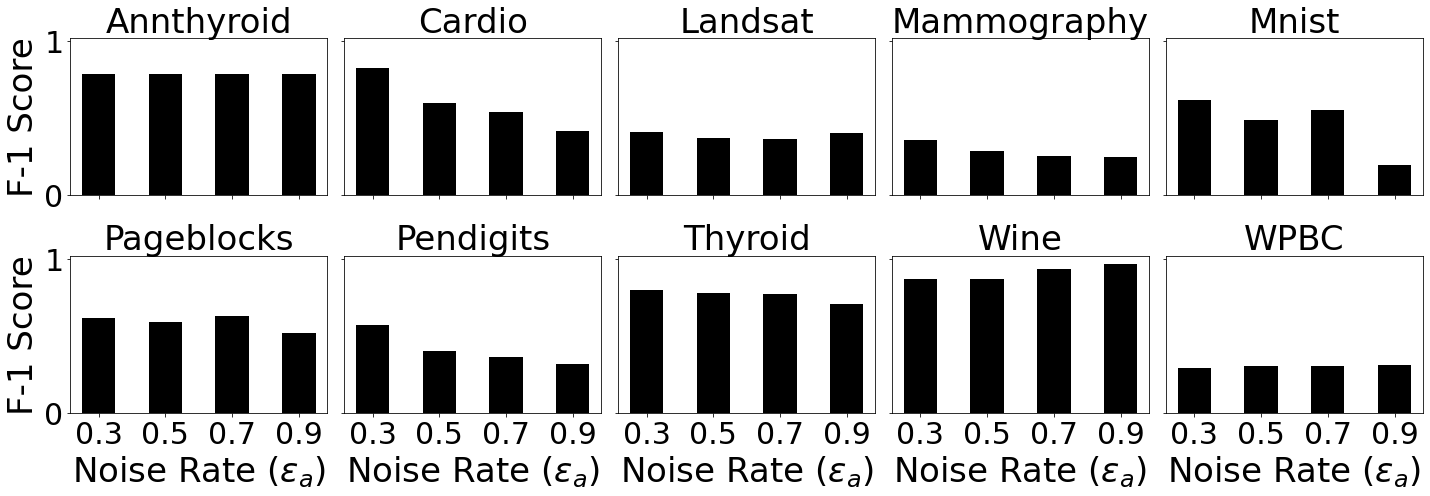

In [31]:
datasets =  ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "wpbc"]
if_batch = ["nonbatch", "batch", "batch", "batch", "batch", "nonbatch", "batch", "batch","nonbatch","nonbatch" ]

fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharey=True, sharex=True)
color = plt.cm.get_cmap('Paired').colors[5]
fontsize = 34
i = 0
for d, b in zip(datasets, if_batch):
    if len(axes.shape)>1:
        row = i//5
        col= i%5
        ax = axes[row][col]
    else:
        ax = axes[i]
    data = pd.read_csv(f"./final_results/varying_noise_rate_analysis/{d}_{b}.csv")
    unity_data = data
    ax.bar(unity_data["rate"], unity_data["f1_mean"], color = "black", width = 0.1)
    
    if d == "wpbc":
        ax.set_title(f"WPBC", fontsize = fontsize)
    else:
        ax.set_title(f"{d.capitalize()}", fontsize = fontsize)

    ax.set_xticks(unity_data["rate"])
    ax.tick_params(axis='x', labelsize=fontsize-4)
    ax.tick_params(axis='y', labelsize=fontsize-4)
    eps = r'$\epsilon_a$'
    if len(axes.shape)>1:
        if col ==0:
            ax.set_ylabel("F-1 Score", fontsize = fontsize)
        if row ==1:
            ax.set_xlabel(f"Noise Rate ({eps})", fontsize=fontsize)
    else:
        if i ==0:
            ax.set_ylabel("F-1 Score", fontsize = fontsize)
        ax.set_xlabel(f"Noise Rate ({eps})", fontsize=fontsize)
    i+=1
plt.tight_layout()

plt.savefig("../figures/experiments/unity_vs_noise_rate.pdf")

## Ablation Study

### Get f1 scores of each module  

In [13]:
# Read the results CSV file
results = pd.read_csv("./final_results/ablation_study/results_ablation.csv")

# Select the top seeds for each method
top_seeds = results.groupby(["Exp", "Dataset", "batch_norm"]).apply(lambda x: x.nlargest(3, "f1")).reset_index(drop=True)

# Group by Method and Dataset, then calculate the mean
results_grouped = top_seeds.groupby(["Exp", "Dataset", "batch_norm"]).mean().reset_index()
results_grouped = top_seeds.groupby(["Exp", "Dataset", "batch_norm"]).agg({'f1': ['mean', 'std']}).reset_index()
results_grouped.columns = [' '.join(col).strip() for col in results_grouped.columns.values]

# Rename columns
results_grouped = results_grouped.rename(columns={'f1 mean': 'f1_mean', 'f1 std': 'f1_std'})
max_f1_idx = results_grouped.groupby(["Exp", "Dataset"])['f1_mean'].idxmax()
result_df = results_grouped.loc[max_f1_idx]

# round the results
result_df['f1_mean'] = result_df['f1_mean'].round(2)
result_df['f1_std'] = result_df['f1_std'].round(2)

result_df

,Exp,Dataset,batch_norm,f1_mean,f1_std
0,UNITY,WPBC,False,0.36,0.02
2,UNITY,annthyroid,False,0.78,0.00
5,UNITY,cardio,True,0.65,0.09
7,UNITY,landsat,True,0.40,0.02
9,UNITY,mammography,True,0.34,0.08
11,UNITY,mnist,True,0.48,0.02
12,UNITY,pageblocks,False,0.63,0.01
15,UNITY,pendigits,True,0.58,0.09
17,UNITY,thyroid,True,0.81,0.02
18,UNITY,wine,False,0.83,0.15


### Create latex for the table 

In [14]:
# Latex code for table with different metrics
def df_to_latex_ab(df, metrics, columns, methods, datasets):    
    # correct names
    df['Exp'] = df['Exp'].replace('agree_only', 'Unity-agree')
    df['Exp'] = df['Exp'].replace('disagree_only', 'Unity-disagree')
    df['Exp'] = df['Exp'].replace('agree_and_disagree', 'Unity-core (a&d)')
    df['Exp'] = df['Exp'].replace('UNITY', 'Unity (complete)')
    df['Exp'] = df['Exp'].replace('refurbishment_only', 'Unity-refurbish')
    

    df["Dataset"] = df["Dataset"].replace("annthyroid", "Annthyroid")
    df["Dataset"] = df["Dataset"].replace("cardio", "Cardio")
    df["Dataset"] = df["Dataset"].replace("mammography", "Mammography")
    df["Dataset"] = df["Dataset"].replace("mnist", "Mnist")
    df["Dataset"] = df["Dataset"].replace("pageblocks", "Pageblocks")
    df["Dataset"] = df["Dataset"].replace("thyroid", "Thyroid")
    df["Dataset"] = df["Dataset"].replace("landsat", "Landsat")
    df["Dataset"] = df["Dataset"].replace("wine", "Wine")
    df["Dataset"] = df["Dataset"].replace("pendigits", "Pendigits")

    df = df.rename(columns={'f1_mean': 'F1'})
    df = df.rename(columns={'auc': 'AUCROC'})
    
    # filter dataset
    df = df[df['Exp'].isin(methods)]
    df = df[df['Dataset'].isin(datasets)]

    num_metrics = len(metrics)  # number of columns without dataset
    num_methods = len(methods)  # number of methods
    num_datasets = len(datasets)  # number of datasets
    
    if num_metrics > 1:  # if more than one metric, use multirow
        # write to latex
        with open('../figures/experiments/ab_tab.tex', 'w') as tab:
            tab.write('\\begin{table*}[t]')
            tab.write('\n \\resizebox{1.0\linewidth}{!}{')
            tab.write('\n \\begin{tabular}{l|' + (num_metrics*num_datasets)*'cc' + '\toprule')  # set up columns and set their width

            # loop through datasets to setup column names
            tab.write("\multirow{2}{*}{\textbf{Method}}")
            tab.write("\cline{2-11}")
            for dataset in datasets:
                tab.write(f' & \n \multicolumn{{{num_metrics}}}{{{dataset}}}')
            tab.write("\\\\ \hline\hline")

            # loop through metrics to setup column names
            for dataset in datasets:
                for metric in metrics:
                    tab.write(f"& {metric}")
                tab.write("\n")
            tab.write("\\\ \hline")
            
            # loop through methods to fill table with values
            for method in methods:
                tab.write(f'\n {method}')
                for dataset in datasets:
                    for metric in metrics:
                        tab.write(f' & {df.loc[(df["Dataset"] == dataset) & (df["Method"] == method), metric].values[0]:.3f}')
                tab.write('\n \\\\')

            tab.write("\hline")
            tab.write("\n \end{tabular}")
            tab.write("\n \caption{Comparison of the State-of-Art}")
            tab.write("\label{tab.compare_methods}")
            tab.write("\n \end{table*}")

    else:  # if we want to use only one metric
        # write to latex
        with open('../figures/experiments/full_ab_results.tex', 'w') as tab:
            tab.write('\\begin{table*}[t]')
            tab.write('\n \\resizebox{1.0\linewidth}{!}{')
            tab.write('\n \\begin{tabular}{l|' + (num_datasets)*'c' + '}' + '\n \\toprule')  # set up columns and set their width

            # loop through datasets to setup column names
            tab.write(" \n \multirow{2}{*}{\\textbf{Method}}")
            tab.write(f"\n & \\multicolumn{{{num_datasets}}}{{c}}{{\\textbf{{Datasets}}}}\\\\")
            tab.write(f"\n \\cline{{2-{num_datasets+1}}}")
            tab.write(f"\n")
            
            for dataset in datasets:
                tab.write(f' & {dataset}')
            tab.write("\\\\ \hline \hline")

            # loop through methods to fill table with values
            for method in methods:
                tab.write(f'\n {method}')
                for dataset in datasets:
                    tab.write(f' & {df.loc[(df["Dataset"] == dataset) & (df["Exp"] == method), metrics[0]].values[0]:.3f}$\pm${df.loc[(df["Dataset"] == dataset) & (df["Exp"] == method), "f1_std"].values[0]:.3f}')
                if method == "IF" or method == "UADB" or method == "SELFIE":
                    tab.write('\n \\\\\hline')
                else:
                    tab.write('\n \\\\')

            tab.write("\\bottomrule")
            tab.write("\n \end{tabular}}")
            tab.write("\n \caption{Ablation Study of Unity and its Core Components (F-1 Scores)}")
            tab.write("\n \label{tab.compare_methods_f1_bathnorm}")
            tab.write("\n \end{table*}")   

    return df

In [15]:
# Read the results CSV file
results = pd.read_csv("./final_results/ablation_study/results_ablation.csv")

# Select the top seeds for each method
top_seeds = results.groupby(["Method", "Dataset", "batch_norm"]).apply(lambda x: x.nlargest(3, "f1")).reset_index(drop=True)

# Select the top seeds for each method
top_seeds = results.groupby(["Exp", "Dataset", "batch_norm"]).apply(lambda x: x.nlargest(3, "f1")).reset_index(drop=True)
results_grouped = top_seeds.groupby(["Exp", "Dataset", "batch_norm"]).mean().reset_index()
results_grouped = top_seeds.groupby(["Exp", "Dataset", "batch_norm"]).agg({'f1': ['mean', 'std']}).reset_index()

results_grouped.columns = [' '.join(col).strip() for col in results_grouped.columns.values]

# Rename columns
results_grouped = results_grouped.rename(columns={'f1 mean': 'f1_mean', 'f1 std': 'f1_std'})
max_f1_idx = results_grouped.groupby(["Exp", "Dataset"])['f1_mean'].idxmax()
result_df = results_grouped.loc[max_f1_idx]

columns = ["Method"]
metrics = ['F1']  # ['F1', 'AUCROC', 'precision', 'recall']
methods = ['Unity-agree', 'Unity-disagree', 'Unity-refurbish', 'Unity-core (a&d)', 'Unity (complete)']
datasets = ['Annthyroid', 'Cardio', 'Landsat', 'Mammography', 'Mnist', 'Pageblocks', 'Pendigits', 'Thyroid', 'Wine', 'WPBC']

df_to_latex_ab(result_df, metrics, columns, methods, datasets)
print("done")

done


## Complexity Analysis

### Create Larger dataset

In [ ]:
n = 1000000  # number of new samples to generate

# read in largest dataset
data = pd.read_csv("../datasets/mammography.csv")

# remove duplicates
features_to_exclude = ['id', 'label']
columns_for_duplicates = data.columns.difference(features_to_exclude)
duplicate_indices = data.duplicated(subset=columns_for_duplicates, keep=False)
data_to_drop = data[duplicate_indices]
data = data.drop(index=data_to_drop.index.difference(data_to_drop.drop_duplicates(subset=columns_for_duplicates).index))
data = data.reset_index(drop=True)

# how many inliers and outliers are needed to keep outlier ratio the same
outlier_ratio = data["label"].mean()
inlier_idx = data[data["label"] == 0].index
outlier_idx = data[data["label"] == 1].index
inlier_samples = data.loc[inlier_idx]
outlier_samples = data.loc[outlier_idx]
n_outliers = int(n * outlier_ratio)
n_inliers = n - n_outliers
print(f"number of outliers to create: {n_outliers}")
print(f"number of inliers to create: {n_inliers}")

# create new outlier samples 
distributions_outliers = {}  # create d distributions for d dimensions of the data
for column in data.columns:
    if column not in features_to_exclude:
        mean, std = norm.fit(outlier_samples[column])
        dist = norm(loc=mean, scale=std)
        distributions_outliers[column] = dist

# create new inlier samples
distribution_inliers = {} # create d distributions for d dimensions of the data
for column in data.columns:
    if column not in features_to_exclude:
        mean, std = norm.fit(inlier_samples[column])
        dist = norm(loc=mean, scale=std)
        distribution_inliers[column] = dist

# create new samples
def generate_sample(distributions):
    sample = {}
    for feature, dist in distributions.items():
        sample[feature] = dist.rvs()
    return sample

new_samples_outliers = [generate_sample(distributions_outliers) for _ in range(n_outliers)]
new_samples_inliers = [generate_sample(distribution_inliers) for _ in range(n_inliers)]

new_samples_outliers_df = pd.DataFrame(new_samples_outliers)
new_samples_outliers_df["label"] = 1  # labels for new samples 
new_samples_outliers_df["id"] = np.arange(data["id"].max() + 1, data["id"].max() + 1 + n_outliers)  # id for new samples

new_samples_inliers_df = pd.DataFrame(new_samples_inliers)
new_samples_inliers_df["label"] = 0 # labels for new samples
new_samples_inliers_df["id"] = np.arange(data["id"].max() + 1 + n_outliers, data["id"].max() + 1 + n_outliers + n_inliers)  # id for new samples

# combine with original data
new_data = pd.concat([data, new_samples_outliers_df, new_samples_inliers_df], ignore_index=True)

# write to csv
new_data.to_csv("../datasets/large/mammography_large.csv", index=False)

### Create Figure

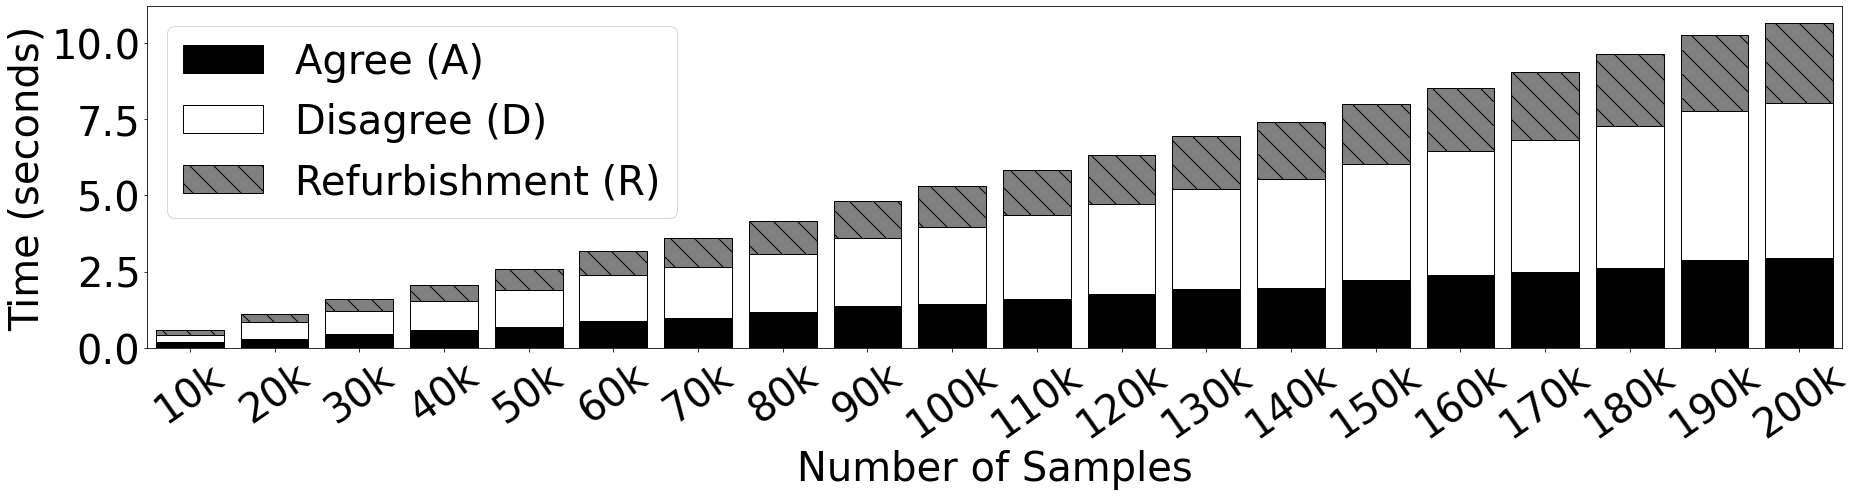

In [16]:
datasets = ["complexity_mammography_10000", "complexity_mammography_20000", "complexity_mammography_30000", "complexity_mammography_40000", "complexity_mammography_50000", 
            "complexity_mammography_60000", "complexity_mammography_70000", "complexity_mammography_80000", "complexity_mammography_90000", "complexity_mammography_100000", 
            "complexity_mammography_110000", "complexity_mammography_120000", "complexity_mammography_130000", "complexity_mammography_140000", "complexity_mammography_150000",
            "complexity_mammography_160000", "complexity_mammography_170000", "complexity_mammography_180000", "complexity_mammography_190000", "complexity_mammography_200000"]

df_times = pd.DataFrame()
color = plt.cm.get_cmap('Paired').colors
fontsize = 40

for dataset in datasets:
    df_eval = pd.read_csv(f"../results/Final_results/complexity_analysis/{dataset}.csv")
    df_eval_time = df_eval[["Dataset", "seed", "epoch", "agree_time", "disagree_time", "refurbishment_time", "training_time"]].copy()

    df_eval_time = df_eval_time.groupby("Dataset").mean().reset_index()
    
    # rename dataset to just the number after the dataset name
    n = df_eval_time["Dataset"].apply(lambda x: int(x.split("_")[-1]))
    df_eval_time["Dataset"] = f"{int(n/1000)}k" # .apply(lambda x: "{:,}".format(x))
    
    df_times = pd.concat([df_times, df_eval_time], ignore_index=True)
    
# Setting up the figure and axis
fig, ax = plt.subplots()
fig.set_size_inches(26, 7)
bar_width = 0.8
index = np.arange(len(df_times))

# Creating bars
# bar0 = ax.bar(index, df_times['training_time'], bar_width, label='Training')
bar1 = ax.bar(index, df_times['agree_time'], bar_width, label='Agree (A)', color="black",  edgecolor='black')
bar2 = ax.bar(index, df_times['disagree_time'], bar_width, bottom=df_times['agree_time'], label='Disagree (D)', color="white", edgecolor='black')
bar3 = ax.bar(index, df_times['refurbishment_time'], bar_width, bottom=df_times['agree_time']+df_times['disagree_time'], label='Refurbishment (R)', color="gray", hatch = '\\',  edgecolor='black')

# add line
# x = df_times["Dataset"]
# y = df_times["agree_time"] + df_times["disagree_time"] + df_times["refurbishment_time"]
# sns.lineplot(x=x, y=y, color='black', linestyle='--', linewidth=4)

# Adding labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=fontsize)
ax.set_ylabel('Time (seconds)', fontsize=fontsize)
ax.set_title('')
ax.set_xticks(index)
ax.set_xticklabels(df_times['Dataset'], fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.xlim(-0.5, 20 - 0.5)
plt.xticks(rotation=35)

plt.tight_layout()
plt.savefig("../figures/experiments/complexity_analysis.pdf")
# Show plot
plt.show()

#### Isolate each component 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


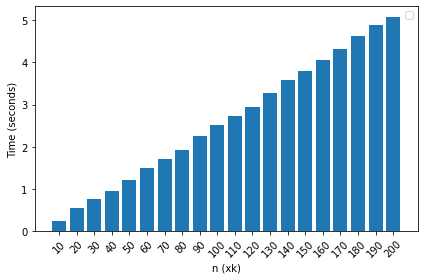

In [17]:
datasets = ["complexity_mammography_10000", "complexity_mammography_20000", "complexity_mammography_30000", "complexity_mammography_40000", "complexity_mammography_50000", 
            "complexity_mammography_60000", "complexity_mammography_70000", "complexity_mammography_80000", "complexity_mammography_90000", "complexity_mammography_100000", 
            "complexity_mammography_110000", "complexity_mammography_120000", "complexity_mammography_130000", "complexity_mammography_140000", "complexity_mammography_150000",
            "complexity_mammography_160000", "complexity_mammography_170000", "complexity_mammography_180000", "complexity_mammography_190000", "complexity_mammography_200000"]

df_times = pd.DataFrame()
for dataset in datasets:
    df_eval = pd.read_csv(f"../results/Final_results/complexity_analysis/{dataset}.csv")
    df_eval_time = df_eval[["Dataset", "seed", "epoch", "agree_time", "disagree_time", "refurbishment_time", "training_time"]].copy()

    df_eval_time = df_eval_time.groupby("Dataset").mean().reset_index()
    
    # rename dataset to just the number after the dataset name
    n = df_eval_time["Dataset"].apply(lambda x: int(x.split("_")[-1]))
    df_eval_time["Dataset"] = int(n/1000)
    
    df_times = pd.concat([df_times, df_eval_time], ignore_index=True)
df_times
    
# Setting up the figure and axis
fig, ax = plt.subplots()

# Width of each bar
bar_width = 0.8

# Positions for the bars
index = np.arange(len(df_times))

# Creating bars
# bar0 = ax.bar(index, df_times['training_time'], bar_width, label='Training')
bar1 = ax.bar(index, df_times['disagree_time'], bar_width, label='')  # agree_time, disagree_time, refurbishment_time, training_time


# Adding labels, title, and legend
ax.set_xlabel('n (xk)')
ax.set_ylabel('Time (seconds)')
ax.set_title('')
ax.set_xticks(index)
ax.set_xticklabels(df_times['Dataset'], rotation=45)
ax.legend()

plt.tight_layout()

# Show plot
plt.show()

## Adaptive Threshold

In [19]:
# create simplified data
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]
batch_dict = {"annthyroid": False, "cardio": True, "landsat": True, "mammography": True, "mnist": True, "pageblocks": False, "pendigits": True, "thyroid": True, "wine": False, "WPBC": False}

final_df = pd.DataFrame(columns=["Dataset", "seed", "batch_norm", "overall_f1", "threshold"])
for dataset in datasets:
    # get the results with GT threshold
    results_no_thresh = pd.read_csv(f"final_results/no_threshold_analysis/no_threshold_{dataset}.csv")
    results_no_thresh = results_no_thresh[results_no_thresh["epoch"].isin([199])][["Dataset", "seed", "batch_norm", "overall_f1"]]
    results_no_thresh = results_no_thresh.rename(columns={"overall_f1": "no_thresh_f1"})

    # get the results with adaptive threshold
    results_thresh = pd.read_csv(f"final_results/sota_comparison/results.csv")
    results_thresh = results_thresh[(results_thresh["Dataset"] == dataset) & (results_thresh["Method"] == "UNITY")][["Dataset", "seed", "batch_norm", "f1"]]
    results_thresh = results_thresh.rename(columns={"f1": "thresh_f1"})

    # fliter batch or no batch
    results_thresh = results_thresh[results_thresh["batch_norm"] == batch_dict[dataset]]
    results_no_thresh = results_no_thresh[results_no_thresh["batch_norm"] == batch_dict[dataset]]

    # change all f1 names to overall_f1
    results_thresh = results_thresh.rename(columns={"thresh_f1": "overall_f1"})
    results_no_thresh = results_no_thresh.rename(columns={"no_thresh_f1": "overall_f1"})

    # add threshold column with the threshold type
    results_thresh["threshold"] = "adaptive"
    results_no_thresh["threshold"] = "gt"

    # append below each other
    results = pd.concat([results_no_thresh, results_thresh], ignore_index=True)

    # append to final df
    final_df = pd.concat([final_df, results], ignore_index=True)

# save as csv
final_df.to_csv("final_results/no_threshold_analysis/final_threshold_data.csv", index=False)


### Paired T-test

In [20]:
def get_data(dataframe, dataset, threshold):
    tmp = dataframe.loc[(dataframe["Dataset"] == dataset) & (dataframe["threshold"] == threshold)]
    tmp = tmp.sort_values("seed")
    tmp = tmp["overall_f1"].to_list()
    return tmp

In [21]:
# read in the data
df_thresh = pd.read_csv("final_results/no_threshold_analysis/final_threshold_data.csv")
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]

results = []
for dataset in datasets:
    data_gt = get_data(df_thresh, dataset, "gt")
    data_adapt = get_data(df_thresh, dataset, "adaptive")

    result_gt_v_adapt = stats.ttest_rel(data_gt, data_adapt)[1]
    
    results.append([dataset, result_gt_v_adapt])
df_results = pd.DataFrame(results, columns=["Dataset", "GT vs Adaptive"])
print(df_results.to_markdown(index=False))

| Dataset     |   GT vs Adaptive |
|:------------|-----------------:|
| annthyroid  |       0.411589   |
| cardio      |       0.483077   |
| landsat     |       0.00126755 |
| mammography |       0.271378   |
| mnist       |       0.596669   |
| pageblocks  |       0.646408   |
| pendigits   |       0.746798   |
| thyroid     |       0.662766   |
| wine        |       0.113195   |
| WPBC        |       0.0454889  |


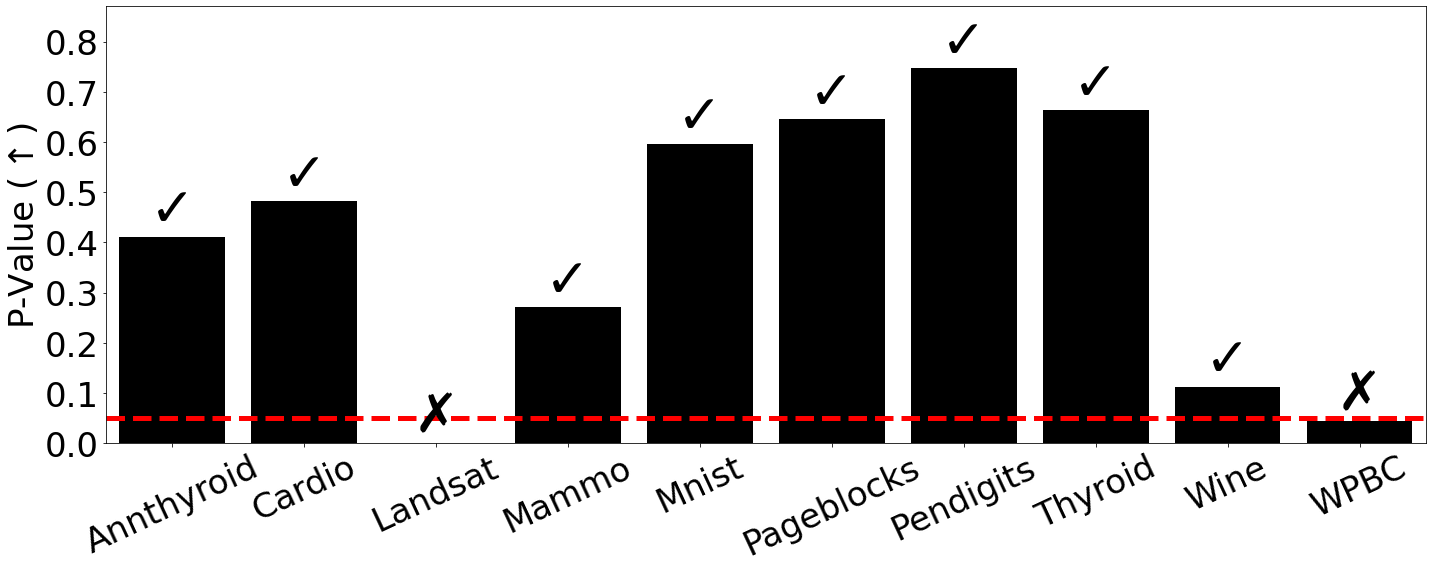

In [22]:
fontsize = 34
plt.figure(figsize=(20, 8))

df_results["Dataset"] = df_results["Dataset"].replace("annthyroid", "Annthyroid")
df_results["Dataset"] = df_results["Dataset"].replace("cardio", "Cardio")
df_results["Dataset"] = df_results["Dataset"].replace("landsat", "Landsat")   
df_results["Dataset"] = df_results["Dataset"].replace("mammography", "Mammo")
df_results["Dataset"] = df_results["Dataset"].replace("mnist", "Mnist")
df_results["Dataset"] = df_results["Dataset"].replace("pageblocks", "Pageblocks")
df_results["Dataset"] = df_results["Dataset"].replace("pendigits", "Pendigits")
df_results["Dataset"] = df_results["Dataset"].replace("thyroid", "Thyroid")
df_results["Dataset"] = df_results["Dataset"].replace("wine", "Wine")
df_results["Dataset"] = df_results["Dataset"].replace("wpbc", "WPBC")

sns.barplot(x='Dataset', y='GT vs Adaptive', data=df_results, color='black')

# Horizontal line at p-value = 0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=5)

plt.title('')
plt.xlabel('')
plt.ylabel(r'P-Value ($\uparrow$)', fontsize=fontsize)
plt.xticks(rotation=25, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

plt.ylim(0, 0.87)

# Annotate bars
for bar, value in zip(plt.gca().patches, df_results['GT vs Adaptive']):
    if value > 0.05:
        plt.gca().annotate('✓', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                           ha='center', va='bottom', fontsize=fontsize+20)
    else:
        plt.gca().annotate('✗', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                           ha='center', va='bottom', fontsize=fontsize+20)

plt.savefig("../figures/experiments/ttest_gt_adaptive.pdf")
plt.show()


## TSNE Plots

In [23]:
def plot(tsne_df, fig_loc = None, fontsize = 16):
    normal = tsne_df[tsne_df["y"] == 0]
    abnormal = tsne_df[tsne_df["y"] == 1]
    plt.scatter(normal["comp-1"], normal["comp-2"], label="Normal", color="steelblue", alpha=0.4)
    plt.scatter(abnormal["comp-1"], abnormal["comp-2"], label="Abnormal", color="darkorange", alpha=0.4)
    plt.legend(fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.tight_layout()
    if fig_loc:
        plt.savefig(fig_loc)
    else:
        plt.show()
    plt.cla()

def tsne_create(tsne_file_name, data= None):
    tsne = TSNE(n_components=2, verbose = 0, perplexity = 100,  random_state=np.random.RandomState(4321))
    features = data.drop(columns=["id", "label","pred_label"])

    x = features.to_numpy()
    z = tsne.fit_transform(x)
    df = pd.DataFrame()

    df["id"] = data["id"]
    df["y"] = data["label"]
    df["pred"] = data["pred_label"]
    df["comp-1"] = z[:, 0]
    df["comp-2"] = z[:, 1]
    return df

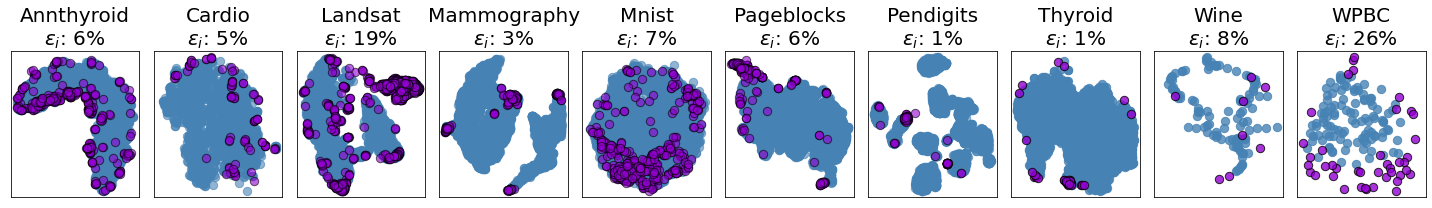

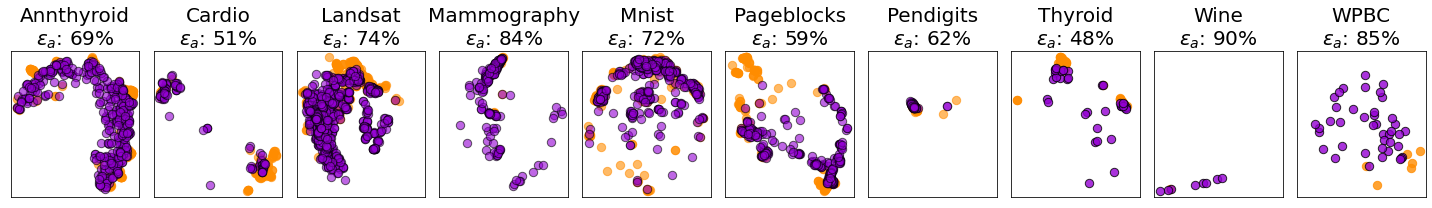

In [24]:
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]
# datasets = ["WPBC", "wine"]
inlier_noise_rates = [6, 5, 19, 3, 7, 6, 1, 1, 8, 26]
outlier_noise_rate = [69, 51, 74, 84, 72, 59, 62, 48, 90, 85]
inlier_fig, inlier_axes = plt.subplots(1, 10, figsize = (20,3))
outlier_fig, outlier_axes = plt.subplots(1, 10, figsize = (20,3))
fontsize = 20
for i, dataset in enumerate(datasets):
    data = pd.read_csv(f"./final_results/tsne/inital_labels/{dataset}_inital_labels.csv")
    tsne_df = tsne_create(f"{dataset}_tsne.csv", data)
    if dataset=='wine':
        min_x = tsne_df["comp-1"].min()
        tsne_df = tsne_df[tsne_df["comp-1"]!=min_x]
    inlier_ax = inlier_axes[i]
    inliers = tsne_df[(tsne_df["y"]==0)]
    outliers = tsne_df[(tsne_df["y"]==1)]
    clean_inliers = tsne_df[(tsne_df["y"]==0) & (tsne_df["pred"]==0)]
    noisy_inliers = tsne_df[(tsne_df["y"]==0) & (tsne_df["pred"]==1)]

    clean_anomalies = tsne_df[(tsne_df["y"]==1) & (tsne_df["pred"]==1)]
    noisy_anomalies = tsne_df[(tsne_df["y"]==1) & (tsne_df["pred"]==0)]
    alpha = 0.8 if dataset in ["thyroid","wine", "WPBC"] else 0.6

    # invisible plots, to make x, y limits
    inlier_ax.scatter(inliers["comp-1"], inliers["comp-2"],  s = 50,  alpha = 0)
    inlier_ax.scatter(outliers["comp-1"], outliers["comp-2"],  s = 50,  alpha = 0)

    inlier_ax.scatter(clean_inliers["comp-1"], clean_inliers["comp-2"], color = 'steelblue', s = 70, label ='Clean Inlier', alpha = alpha)
    inlier_ax.scatter(noisy_inliers["comp-1"], noisy_inliers["comp-2"], color = 'darkviolet', edgecolor='black',s = 70,
                          label ='Noisy inlier', alpha = alpha, zorder = 10)

    x_limits = inlier_ax.get_xlim()
    y_limits = inlier_ax.get_ylim()
    e_i = r'$\epsilon_i$'
    if dataset == "WPBC":
        inlier_ax.set_title(f"{dataset}\n{e_i}: {inlier_noise_rates[i]}%", fontsize = fontsize)
    else: 
        inlier_ax.set_title(f"{dataset.capitalize()}\n{e_i}: {inlier_noise_rates[i]}%", fontsize = fontsize)

    outlier_ax = outlier_axes[i]
    outlier_ax.scatter(clean_anomalies["comp-1"], clean_anomalies["comp-2"], color = 'darkorange',s = 70, label ='Clean anomaly', alpha = alpha)
    outlier_ax.scatter(noisy_anomalies["comp-1"], noisy_anomalies["comp-2"], color = 'darkviolet',edgecolor='black', s = 70,
                        label ='Noisy anomaly', alpha =alpha, zorder = 10)

    # Overlay hatches using patches
    outlier_ax.set_xlim(x_limits)
    outlier_ax.set_ylim(y_limits)
    e_a = r'$\epsilon_a$'
    if dataset == "WPBC":
        outlier_ax.set_title(f"{dataset}\n{e_a}: {outlier_noise_rate[i]}%", fontsize = fontsize)
    else:
        outlier_ax.set_title(f"{dataset.capitalize()}\n{e_a}: {outlier_noise_rate[i]}%", fontsize = fontsize)

    inlier_ax.set_xticks([])
    inlier_ax.set_yticks([])
    outlier_ax.set_xticks([])
    outlier_ax.set_yticks([])

    if i ==0:
        legend_fontsize = 34
        handles1, labels1 = inlier_ax.get_legend_handles_labels()
        # handles2, labels2 = outlier_ax.get_legend_handles_labels()
        fig_legend_inlier = plt.figure(figsize=(2, 0.06))
        fig_legend_inlier.legend(handles1,labels1, loc='center', ncol = 3, fontsize = legend_fontsize -28)
        # fig_legend.gca().add_artist(legend)
        fig_legend_inlier.gca().set_axis_off()  # Hide the axes
        fig_legend_inlier.tight_layout()
        fig_legend_inlier.savefig("../figures/experiments/initial_label_tsne_inlier_legend.png", bbox_inches='tight', dpi = 300)

        handles2, labels2 = outlier_ax.get_legend_handles_labels()
        fig_legend_outlier = plt.figure(figsize=(2, 0.1))
        fig_legend_outlier.legend(handles2,labels2, loc='center', ncol = 3, fontsize = legend_fontsize -28)

        # fig_legend.gca().add_artist(legend)
        fig_legend_outlier.gca().set_axis_off()  # Hide the axes
        fig_legend_outlier.tight_layout()
        fig_legend_outlier.savefig("../figures/experiments/initial_label_tsne_outlier_legend.png", bbox_inches='tight', dpi = 300)
    
    inlier_fig.tight_layout()
    inlier_fig.savefig("../figures/experiments/initial_label_tsne_inlier.png", dpi = 300)
    outlier_fig.tight_layout()
    outlier_fig.savefig("../figures/experiments/initial_label_tsne_outlier.png", dpi = 300)

## System Evaluation

### Bar charts

In [25]:
def get_selection_nums(gt_class_data, label, initial_labels_data):
    gt_class_data = gt_class_data[gt_class_data["gt"] == label] # the gt class
    noisy_num = []
    clean_num = []

    noisy_num.append(len(initial_labels_data[(initial_labels_data["label"]==label )& (initial_labels_data["pred_label"] == 1 - label)]))
    clean_num.append(len(initial_labels_data[(initial_labels_data["label"]==label )& (initial_labels_data["pred_label"] == label)]))

    agreement_selection = gt_class_data[(gt_class_data["selection"] == 1)]
    agreement_selection_noisy = agreement_selection[
        (agreement_selection["gt"] == label) & (agreement_selection["model1_pred"] == 1-label)]
    agreement_selection_clean = agreement_selection[
        (agreement_selection["gt"] == label) & (agreement_selection["model1_pred"] == label)]
    noisy_num.append(len(agreement_selection_noisy))
    clean_num.append(len(agreement_selection_clean))

    disagreement_selection = gt_class_data[(gt_class_data["selection"] == 2)]
    disagreement_selection_noisy = disagreement_selection[
        (disagreement_selection["gt"] == label) & (disagreement_selection["model1_pred"] == 1-label)]
    disagreement_selection_clean = disagreement_selection[
        (disagreement_selection["gt"] == label) & (disagreement_selection["model1_pred"] == label)]
    noisy_num.append(len(disagreement_selection_noisy)+noisy_num[-1])
    clean_num.append(len(disagreement_selection_clean)+clean_num[-1])

    refurbish_selection = gt_class_data[(gt_class_data["selection"] == 3)]
    refurbish_selection_noisy = refurbish_selection[
        (refurbish_selection["gt"] == label) & (refurbish_selection["label_after_refub"] == 1-label)]
    refurbish_selection_clean = refurbish_selection[
        (refurbish_selection["gt"] == label) & (refurbish_selection["label_after_refub"] == label)]
    noisy_num.append(len(refurbish_selection_noisy)+noisy_num[-1])
    clean_num.append(len(refurbish_selection_clean)+clean_num[-1])

    return np.array(noisy_num), np.array(clean_num)

#### dataset: annthyroid ####
Noisy inliers [372  23  32  84]
Clean inliers [6156 1425 1640 4513]
Noisy outliers [372   0  42  53]
Clean outliers [162 142 181 345]


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))


Percentage of samples still selected: 0.7073067119796091


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))


#### dataset: cardio ####
Noisy inliers [84 10 12 19]
Clean inliers [1563  357  411 1130]
Noisy outliers [84  6 18 28]
Clean outliers [ 91  36  43 109]
Percentage of samples still selected: 0.7058177826564215
#### dataset: landsat ####
Noisy inliers [987 180 207 688]
Clean inliers [4115  618  765 2901]


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))


Noisy outliers [987 283 348 595]
Clean outliers [346  46  76 234]
Percentage of samples still selected: 0.6865578865578865
#### dataset: mammography ####
Noisy inliers [216  25  36 115]
Clean inliers [7379 1690 2100 5341]
Noisy outliers [216  24  38  65]
Clean outliers [37 46 62 82]
Percentage of samples still selected: 0.7139398572884812
#### dataset: mnist ####


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))


Noisy inliers [497  83 102 243]
Clean inliers [6406  931 1190 4398]
Noisy outliers [497  37  76 244]
Clean outliers [203 131 151 284]
Percentage of samples still selected: 0.6798632118900434
#### dataset: pageblocks ####
Noisy inliers [290  14  34 113]
Clean inliers [4593 1036 1212 3350]
Noisy outliers [290  23  44  77]
Clean outliers [220 144 165 277]
Percentage of samples still selected: 0.7077693306137586
#### dataset: pendigits ####


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums

Noisy inliers [104   0   5  28]
Clean inliers [6610 1561 2128 4866]
Noisy outliers [104   1  15  21]
Clean outliers [52 43 45 83]
Percentage of samples still selected: 0.7275109170305677
#### dataset: thyroid ####
Noisy inliers [36  1  2  8]
Clean inliers [3527  822 1070 2558]


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums

Noisy outliers [36  0  7  7]
Clean outliers [57 21 25 61]
Percentage of samples still selected: 0.7204595185995624
#### dataset: wine ####
Noisy inliers [8 0 0 0]
Clean inliers [111  25  31  82]
Noisy outliers [8 0 0 0]
Clean outliers [2 2 4 8]
Percentage of samples still selected: 0.6976744186046512
#### dataset: WPBC ####


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))


Noisy inliers [41 10 11 23]
Clean inliers [110  24  28  79]
Noisy outliers [41  4  8 24]
Clean outliers [ 6  4  6 13]
Percentage of samples still selected: 0.702020202020202


C:\Users\denni\AppData\Local\Temp\ipykernel_6356\2927014278.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))


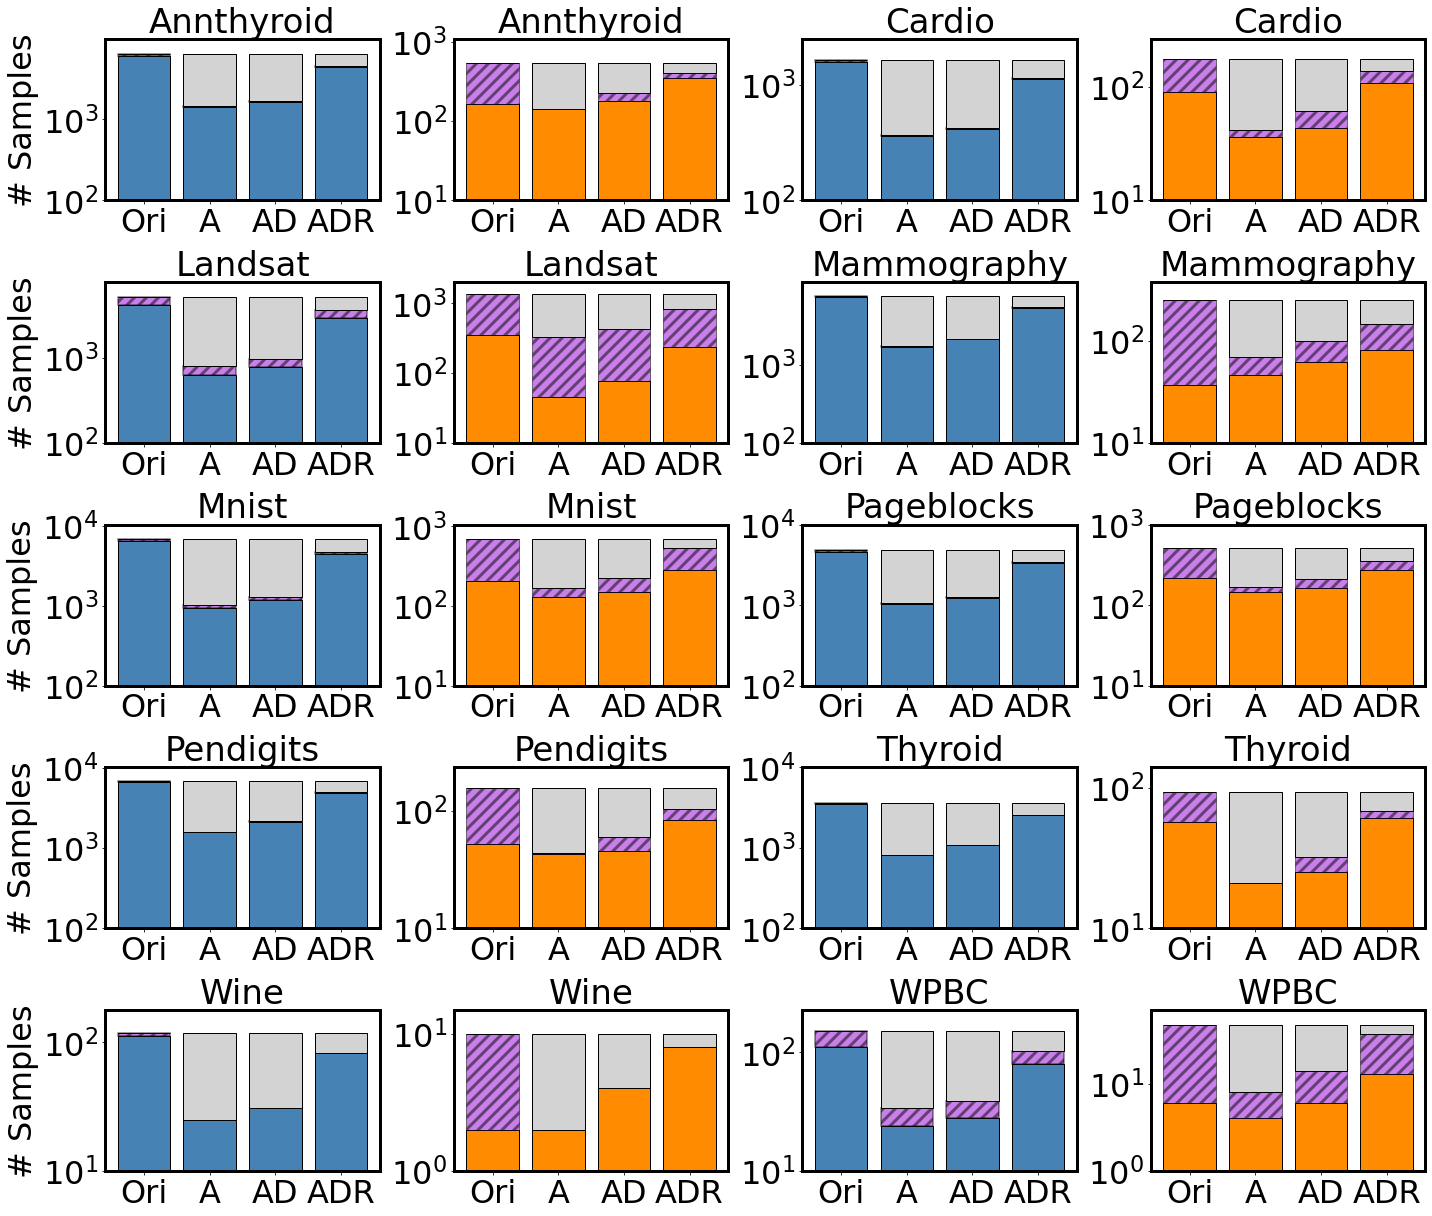

<Figure size 720x72 with 0 Axes>

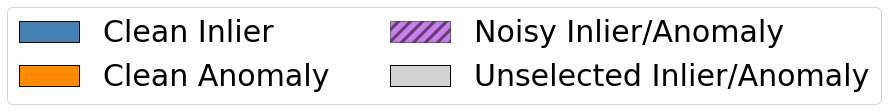

In [11]:
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]
if_batches = ["nonbatch", "batch", "batch", "batch", "batch", "nonbatch", "batch", "batch", "nonbatch", "nonbatch"]
seeds = [6, 4, 7,3,6, 3,9,7,2,1]
fig, axes = plt.subplots(5, 4, figsize = (20, 17))
legend_fig = plt.figure(figsize = (10, 1))
fontsize = 34
plt.rcParams['hatch.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 3.0 
# plt.minorticks_off()
for i, (dataset, if_batch, seed) in enumerate(zip(datasets, if_batches, seeds)):
    print(f"#### dataset: {dataset} ####")
    if os.path.exists(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv"):
        data = pd.read_csv(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv")
    else:
        data = pd.read_csv(f"./final_results/system_evaluation/counts/evaluation_tsne_{dataset}.csv")
        data = data[(data["epoch"]==199) & (data["batch_norm"]== (if_batch=="batch")) & (data["seed"]==seed)]
        data.to_csv(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv", index =False)

    initial_labels_data = pd.read_csv(f"./final_results/tsne/inital_labels/{dataset}_inital_labels.csv")

    rol = i // 2
    inlier_col= (i % 2)*2
    inlier_ax = axes[rol][inlier_col]
    noisy_inlier_nums, clean_inlier_nums = get_selection_nums(data, 0, initial_labels_data)
    print(f"Noisy inliers {noisy_inlier_nums}")
    print(f"Clean inliers {clean_inlier_nums}")
    bars1 = inlier_ax.bar(np.arange(0, len(clean_inlier_nums)), clean_inlier_nums, color = 'steelblue', label ='Clean Inlier', edgecolor = 'black')
    bars2 = inlier_ax.bar(np.arange(0, len(noisy_inlier_nums)), noisy_inlier_nums, bottom = clean_inlier_nums,color = 'darkviolet',
                    hatch = '//',label ='Noisy Inlier/Anomaly', edgecolor = 'black', alpha = 0.5)
    [bar.set_linewidth(1.5) for bar in bars2]
    bars3 = unselected_inliers = noisy_inlier_nums[0] + clean_inlier_nums[0] - noisy_inlier_nums - clean_inlier_nums
    inlier_ax.bar(np.arange(0, len(noisy_inlier_nums)), unselected_inliers, bottom = clean_inlier_nums + noisy_inlier_nums,color = 'lightgrey',
                    edgecolor = 'black',
                    label ='Unselected Inlier/Anomaly')
    inlier_ax.set_xticks(np.arange(0, len(noisy_inlier_nums)))
    inlier_ax.set_xticklabels(["Ori","A","AD","ADR"], fontsize = fontsize -2)
    inlier_ax.set_yscale("log")
    ylim_sclae = 1.5
    # ylim_sclae = 1.5 if i !=0 else 2
    inlier_ax.set_ylim((0, (noisy_inlier_nums[0] + clean_inlier_nums[0])*ylim_sclae))
    inlier_ax.tick_params(axis='both', which='major', labelsize=fontsize -2)
    inlier_ax.tick_params(axis='both', which='minor', labelsize=fontsize -4)
    inlier_ax.minorticks_off()
    if i in[0,1,  2, 3]:
        inlier_ax.set_yticks((100, 1000))
    if i in [4, 5, 6, 7]:
        inlier_ax.set_yticks((100, 1000, 10000))
    if i in[8, 9]: 
        inlier_ax.set_yticks((10, 100))
 
    if dataset == "WPBC":
        inlier_ax.set_title(f"{dataset}", fontsize = fontsize)
    else:
        inlier_ax.set_title(f"{dataset.capitalize()}", fontsize = fontsize)
    if inlier_col ==0:
        inlier_ax.set_ylabel("# Samples", fontsize = fontsize -2)

    outlier_col= (i % 2)*2+1
    outlier_ax = axes[rol][outlier_col]
    noisy_outlier_nums, clean_outlier_nums = get_selection_nums(data, 1, initial_labels_data)
    print(f"Noisy outliers {noisy_outlier_nums}")
    print(f"Clean outliers {clean_outlier_nums}")
    bars4 = outlier_ax.bar(np.arange(0, len(clean_outlier_nums)), clean_outlier_nums, color = 'darkorange', label ='Clean Anomaly', edgecolor = 'black')
    bars5 = outlier_ax.bar(np.arange(0, len(noisy_outlier_nums)), noisy_outlier_nums, bottom = clean_outlier_nums,color = 'darkviolet',
                    hatch = '//',label ='Noisy Inlier/Anomaly', edgecolor = 'black', alpha = 0.5)
    
    # print percentage of samples still selected 
    print(f"Percentage of samples still selected: {(noisy_outlier_nums[-1] + clean_outlier_nums[-1] + noisy_inlier_nums[-1] + clean_inlier_nums[-1])/(noisy_outlier_nums[0] + clean_outlier_nums[0] + noisy_inlier_nums[0] + clean_inlier_nums[0])}")


    unselected_outliers = noisy_outlier_nums[0] + clean_outlier_nums[0] - noisy_outlier_nums - clean_outlier_nums
    outlier_ax.bar(np.arange(0, len(unselected_outliers)), unselected_outliers, bottom = clean_outlier_nums + noisy_outlier_nums,color = 'lightgrey',
                    edgecolor = 'black',
                    label ='Unselected Inlier/Anomaly')
    outlier_ax.set_yscale("log")
    outlier_ax.tick_params(axis='both', which='major', labelsize=fontsize -2)
    outlier_ax.tick_params(axis='both', which='minor', labelsize=fontsize -4)

    ylim_sclae = 1.5 if i !=0 else 2
    outlier_ax.set_ylim((0, (noisy_outlier_nums[0] + clean_outlier_nums[0])*ylim_sclae))
    outlier_ax.set_xticks(np.arange(0, len(unselected_outliers)))
    outlier_ax.set_xticklabels(["Ori","A","AD","ADR"], fontsize = fontsize -2)
    outlier_ax.minorticks_off()
    if i in[0, 2,4, 5]:
        outlier_ax.set_yticks((10, 100, 1000))
    if i in[1, 3,6, 7]:
        outlier_ax.set_yticks((10, 100))
    if i in [8, 9]:
        outlier_ax.set_yticks((1, 10))

    if dataset == "WPBC":
        outlier_ax.set_title(f"{dataset}", fontsize = fontsize)
    else:
        outlier_ax.set_title(f"{dataset.capitalize()}", fontsize = fontsize)

    if i == 0:
        handles1, labels1 = inlier_ax.get_legend_handles_labels()
        handles2, labels2 = outlier_ax.get_legend_handles_labels()
        handles = handles1[:-2] + handles2
        labels = labels1[:-2] + labels2
        fig_legend = plt.figure(figsize=(8, 1))
        legend = fig_legend.legend(handles,labels, loc='center', ncol = 2, fontsize = fontsize -4)
        fig_legend.gca().set_axis_off()

        fig_legend.tight_layout()
        fig_legend.savefig("../figures/experiments/selection_barchart_legend.png", bbox_inches='tight', dpi = 300)

fig.tight_layout()
# plt.show()
fig.savefig("../figures/experiments/selection_barchart.png", dpi = 300)

### Line Charts

dataset: annthyroid
xfold Inliers: 4.428571428571429
xfold Outliers: 7.018867924528302
dataset: cardio
xfold Inliers: 4.421052631578948
xfold Outliers: 3.0
dataset: landsat
xfold Inliers: 1.434593023255814
xfold Outliers: 1.6588235294117648
dataset: mammography
xfold Inliers: 1.8782608695652172
xfold Outliers: 3.323076923076923
dataset: mnist
xfold Inliers: 2.0452674897119345
xfold Outliers: 2.0368852459016393
dataset: pageblocks
xfold Inliers: 2.566371681415929
xfold Outliers: 3.7662337662337664
dataset: pendigits
xfold Inliers: 3.7142857142857144
xfold Outliers: 4.9523809523809526
dataset: thyroid
xfold Inliers: 4.5
xfold Outliers: 5.142857142857142
dataset: wine
xfold Inliers: inf
xfold Outliers: inf
dataset: WPBC
xfold Inliers: 1.7826086956521738
xfold Outliers: 1.7083333333333335


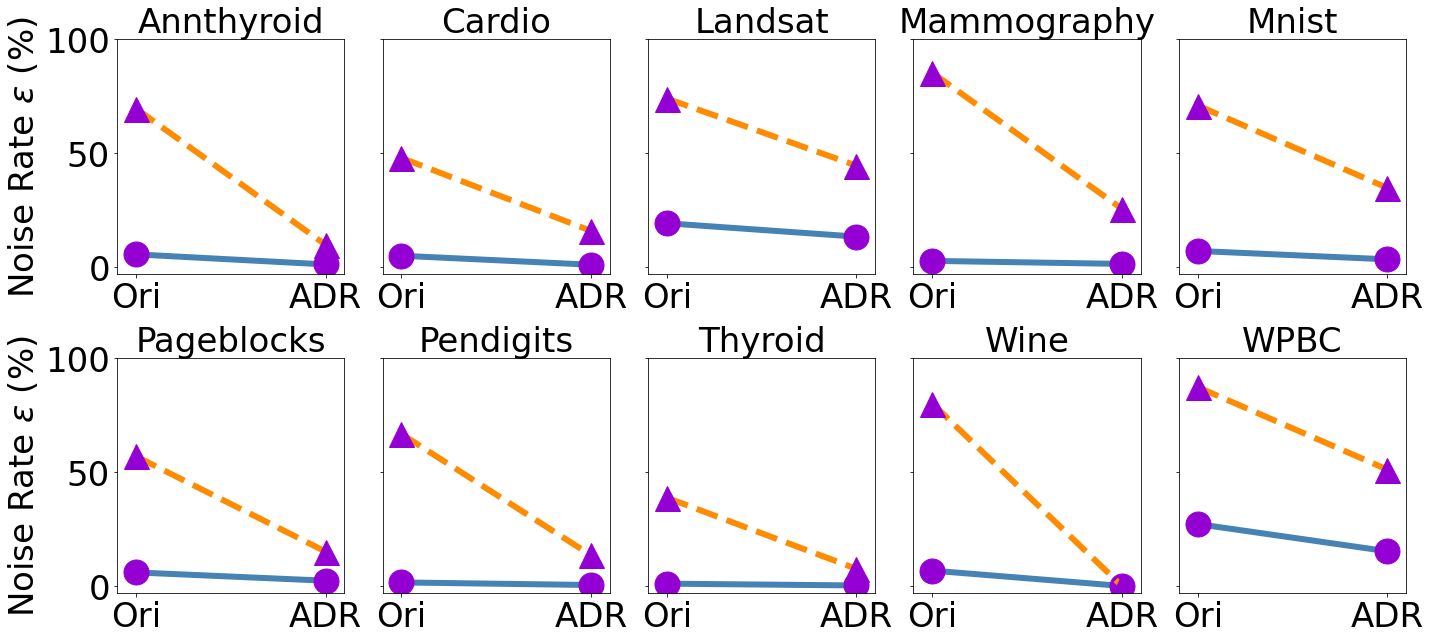

<Figure size 720x72 with 0 Axes>

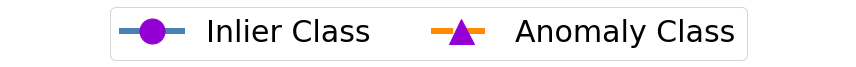

In [27]:
datasets = ["annthyroid", "cardio", "landsat", "mammography", "mnist", "pageblocks", "pendigits", "thyroid", "wine", "WPBC"]
if_batches = ["nonbatch", "batch", "batch", "batch", "batch", "nonbatch", "batch", "batch", "nonbatch", "nonbatch"]
seeds = [6, 4, 7,3,6, 3,9,7,2,1]
fig, axes = plt.subplots(2, 5, figsize = (20,9), sharey=True)
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.1)

legend_fig = plt.figure(figsize = (10, 1))
fontsize = 34

for i, (dataset, if_batch, seed) in enumerate(zip(datasets, if_batches, seeds)):
    print(f"dataset: {dataset}")
    if os.path.exists(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv"):
        data = pd.read_csv(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv")
    else:
        data = pd.read_csv(f"./final_results/system_evaluation/counts/evaluation_tsne_{dataset}.csv")
        data = data[(data["epoch"]==199) & (data["batch_norm"]== (if_batch=="batch")) & (data["seed"]==seed)]
        # data = data[data["epoch"]==199]
        data.to_csv(f"./final_results/system_evaluation/counts_optimal/evaluation_tsne_{dataset}_optimal.csv", index =False)

    initial_labels_data = pd.read_csv(f"./final_results/tsne/inital_labels/{dataset}_inital_labels.csv")

    row, col = divmod(i, 5)
    ax = axes[row][col]
    
    # Inliers
    len_dataset_inliers = len(initial_labels_data[initial_labels_data["label"] == 0])
    noisy_inlier_nums, clean_inlier_nums = get_selection_nums(data, 0, initial_labels_data)
    noise_rates_inliers = np.array([noisy_inlier_nums[0] / len_dataset_inliers, noisy_inlier_nums[-1] / len_dataset_inliers])
    noise_rates_inliers = noise_rates_inliers * 100
    # print(f"Noisy inliers {noisy_inlier_nums}")
    # print(f"orig inlier noise rate: {noisy_inlier_nums[0] / len_dataset_inliers}")
    # print(f"final inlier noise rate: {noisy_inlier_nums[-1] / len_dataset_inliers}")
    print(f"xfold Inliers: {(noisy_inlier_nums[0] / len_dataset_inliers) / (noisy_inlier_nums[-1] / len_dataset_inliers)}")

    # Outliers
    len_dataset_outliers = len(initial_labels_data[initial_labels_data["label"] == 1])
    noisy_outlier_nums, clean_outlier_nums = get_selection_nums(data, 1, initial_labels_data)
    noise_rates_outliers = np.array([noisy_outlier_nums[0] / len_dataset_outliers, noisy_outlier_nums[-1] / len_dataset_outliers])
    noise_rates_outliers = noise_rates_outliers * 100
    # print(f"Noisy outliers {noisy_outlier_nums}")
    # print(f"orig outlier noise rate: {noisy_outlier_nums[0] / len_dataset_outliers}")
    # print(f"final outlier noise rate: {noisy_outlier_nums[-1] / len_dataset_outliers}")
    print(f"xfold Outliers: {(noisy_outlier_nums[0] / len_dataset_outliers) / (noisy_outlier_nums[-1] / len_dataset_outliers)}")

    # print(" ")

    if dataset == "WPBC":
        ax.set_title(f"{dataset}", fontsize=fontsize)
    else:
        ax.set_title(f"{dataset.capitalize()}", fontsize=fontsize)

    ax.plot(np.arange(0, 2), noise_rates_inliers, color='steelblue', label='Inlier Class', marker='o', linewidth=6, markersize=25, markerfacecolor='darkviolet', markeredgecolor='darkviolet')
    ax.plot(np.arange(0, 2), noise_rates_outliers, color='darkorange', label='Anomaly Class', marker='^', linewidth=6, markersize=25, linestyle ='dashed', markerfacecolor='darkviolet', markeredgecolor='darkviolet')
    ax.set_ylim((-3, 100))
    ax.set_xlim((-0.1, 1.1))
    ax.set_xticks(np.arange(0, 2))
    ax.set_xticklabels(["Ori", "ADR"], fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

    if i == 0:
        handles1, labels1 = ax.get_legend_handles_labels()
        fig_legend = plt.figure(figsize=(12, 1))
        legend = fig_legend.legend(handles1, labels1, loc='center', ncol=2, fontsize=fontsize - 4)
        fig_legend.gca().set_axis_off()  # Hide the axes
        fig_legend.tight_layout()

    if col == 0:
        epsilon = r'$\epsilon$'
        ax.set_ylabel(f'Noise Rate {epsilon} (%)', fontsize=fontsize)

# save fig
fig.tight_layout()
fig.savefig("../figures/experiments/selection_linechart.pdf")

# save legend
fig_legend.savefig("../figures/experiments/selection_linechart_legend.pdf", bbox_inches='tight')    